# Tutorial: Learning how to use Tune

<img src="https://github.com/ray-project/tutorial/blob/master/tune_exercises/tune.png?raw=1" alt="Tune Logo" width="400"/>


Tuning hyperparameters is often the most expensive part of the machine learning workflow. Tune is built to address this, demonstrating an efficient and scalable solution for this pain point. Note that this example depends on Tensorflow 2.0.

**Code**: https://github.com/ray-project/ray/tree/master/python/ray/tune

**Examples**: https://github.com/ray-project/ray/tree/master/python/ray/tune/examples

**Documentation**: http://ray.readthedocs.io/en/latest/tune.html

**Mailing List** https://groups.google.com/forum/#!forum/ray-dev

In [ ]:
## If you are running on Google Colab, uncomment below to install the necessary dependencies 
## before beginning the exercise.

print("Setting up colab environment")
!pip uninstall -y -q pyarrow
!pip install -q -U ray[tune]
!pip install -q ray[debug]

# A hack to force the runtime to restart, needed to include the above dependencies.
print("Done installing! Restarting via forced crash (this is not an issue).")
import os
os._exit(0)

Setting up colab environment


In [1]:
## If you are running on Google Colab, please install TensorFlow 2.0 by uncommenting below..

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

This tutorial will step through a couple key steps of the hyperparameter tuning process with Tune. 

1. Visualizing the data.
2. Creating a model training procedure (using Keras).
3. Tuning the model by adapting the above model training procedure to **use Tune**.
4. Analyzing the model created by Tune.

Note that this uses Tune's **function-based API**. This is mainly for prototyping. A later tutorial will cover Tune's more powerful **class-based Trainable** API.

In [2]:
import numpy as np
np.random.seed(0)

import tensorflow as tf
try:
    tf.get_logger().setLevel('INFO')
except Exception as exc:
    print(exc)
import warnings
warnings.simplefilter("ignore")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import ray
from ray import tune
from ray.tune.examples.utils import get_iris_data

import inspect
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Visualize your data

Let's first take a look at the distribution of the dataset.

The Iris data sets consists of 3 different types of iris flowers’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray,

The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.

### The goal of this tutorial is to have a model that can accurately predict the true label given a 4-tuple of Sepal Length, Sepal Width, Petal Length and Petal Width.

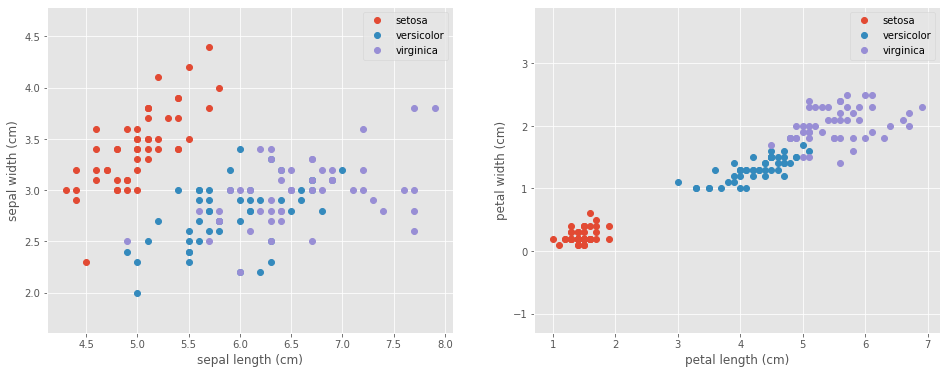

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
true_data = iris['data']
true_label = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

def plot_data(X, y):
    # Visualize the data sets
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for target, target_name in enumerate(names):
        X_plot = X[y == target]
        plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.axis('equal')
    plt.legend();

    plt.subplot(1, 2, 2)
    for target, target_name in enumerate(names):
        X_plot = X[y == target]
        plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
    plt.xlabel(feature_names[2])
    plt.ylabel(feature_names[3])
    plt.axis('equal')
    plt.legend();
    
plot_data(true_data, true_label)

## Creating a model training procedure (using Keras)

Now, let's define a function that will take in some hyperparameters and return a model that we can then use to train.

In [4]:
def create_model(learning_rate, dense_1, dense_2):
    assert learning_rate > 0 and dense_1 > 0 and dense_2 > 0, "Did you set the right configuration?"
    model = Sequential()
    model.add(Dense(int(dense_1), input_shape=(4,), activation='relu', name='fc1'))
    model.add(Dense(int(dense_2), activation='relu', name='fc2'))
    model.add(Dense(3, activation='softmax', name='output'))
    optimizer = SGD(lr=learning_rate)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Below is a function that trains the model using the ``create_model`` function and returns the trained model.

In [5]:
def train_on_iris():
    train_x, train_y, test_x, test_y = get_iris_data()
    model = create_model(learning_rate=0.1, dense_1=2, dense_2=2)
    # This saves the top model. `accuracy` is only available in TF2.0.
    checkpoint_callback = ModelCheckpoint(
        "model.h5", monitor='accuracy', save_best_only=True, save_freq=2)

    # Train the model
    model.fit(
        train_x, train_y, 
        validation_data=(test_x, test_y),
        verbose=0, batch_size=10, epochs=20, callbacks=[checkpoint_callback])
    return model

Let's quickly train the model on the dataset. The accuracy should be quite low.

In [6]:
original_model = train_on_iris()  # This trains the model and returns it.
train_x, train_y, test_x, test_y = get_iris_data()
original_loss, original_accuracy = original_model.evaluate(test_x, test_y, verbose=0)
print("Loss is {:0.4f}".format(original_loss))
print("Accuracy is {:0.4f}".format(original_accuracy))

Loss is 1.0908
Accuracy is 0.3684


## Integrate with Tune

Now, let's use Tune to optimize a model that learns to classify Iris. This will happen in two parts - **modifying** the training function to support Tune, and then **configuring** Tune.

Let's first define a callback function to report intermediate training progress back to Tune.

In [7]:
import tensorflow.keras as keras
from ray import tune


class TuneReporterCallback(keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch.
    """

    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()

    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        tune.report(keras_info=logs, mean_accuracy=logs.get("accuracy"), mean_loss=logs.get("loss"))


### Integration Part 1: Modifying the Training Function

**Instructions** Follow the next 2 steps for modifying the ``train_iris`` function to support Tune.

1. Change the signature of the function to take in a hyperparameter dictionary. This function will be called on a Ray.

```python
def tune_iris(config)
```
    
    
2. Pass in the configuration values into ``create_model``:

```python
model = create_model(learning_rate=config["lr"], dense_1=config["dense_1"], dense_2=config["dense_2"])
```

In [11]:
def tune_iris(config):  # TODO: Change me.
    train_x, train_y, test_x, test_y = get_iris_data()
    model = create_model(learning_rate=config["lr"], dense_1=config["dense_1"], dense_2=config["dense_2"])  # TODO: Change me.
    checkpoint_callback = ModelCheckpoint(
        "model.h5", monitor='loss', save_best_only=True, save_freq=2)

    # Enable Tune to make intermediate decisions by using a Tune Callback hook. This is Keras specific.
    callbacks = [checkpoint_callback, TuneReporterCallback()]
    
    # Train the model
    model.fit(
        train_x, train_y, 
        validation_data=(test_x, test_y),
        verbose=0, 
        batch_size=10, 
        epochs=20, 
        callbacks=callbacks)
    
assert len(inspect.getargspec(tune_iris).args) == 1, "The `tune_iris` function needs to take in the arg `config`."

# print("Test-running to make sure this function will run correctly.")
# tune.track.init()  # For testing purposes only.
# tune_iris({"lr": 0.1, "dense_1": 4, "dense_2": 4})
# print("Success!")

### Integration Part 2: Configuring Tune to tune hyperparameters.

**Instructions** Follow the next 2 steps to configure Tune to identify the top hyperparameters.

1. Designate the hyperparameter space. 

```python
hyperparameter_space = {
    "lr": tune.loguniform(0.001, 0.1),  
    "dense_1": tune.uniform(2, 128),
    "dense_2": tune.uniform(2, 128),
}
```
2. Increase the number of samples. The more trials we evaluate, the more chances we choose a good model.

```python
num_samples = 20
```
#### FAQ: How does parallelism work in Tune?


Setting ``num_samples`` will run a *total* of 20 trials (hyperparameter configuration samples). However, not all of them will run at once. The max training concurrency will be the number of CPU cores on the machine you're running on. For a 2-core machine, 2 models will be trained concurrently. When one is finished, a new training process will start with a new hyperparameter configuration sample. 

Each trial will run on a new Python process. The python process is killed when the trial is finished.


#### FAQ: How do I debug things in Tune?

The `error file` column will show up in the output. Run the below cell with the ``error file path`` path to diagnose your issue.

```
! cat /home/ubuntu/tune_iris/tune_iris_c66e1100_2019-10-09_17-13-24x_swb9xs/error_2019-10-09_17-13-29.txt
```

# Launch a Tune hyperparameter search

In [12]:
# This seeds the hyperparameter sampling.
import numpy as np; np.random.seed(5)  
hyperparameter_space = {
    "lr": tune.loguniform(0.001, 0.1),  
    "dense_1": tune.uniform(2, 128),
    "dense_2": tune.uniform(2, 128),
}  # TODO: Fill me out.
num_samples = 20  # TODO: Fill me out.

####################################################################################################
################ This is just a validation function for tutorial purposes only. ####################
HP_KEYS = ["lr", "dense_1", "dense_2"]
assert all(key in hyperparameter_space for key in HP_KEYS), (
    "The hyperparameter space is not fully designated. It must include all of {}".format(HP_KEYS))
######################################################################################################

ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)
# We clean out the logs before running for a clean visualization later.
! rm -rf ~/ray_results/tune_iris

analysis = tune.run(
    tune_iris, 
    verbose=1, 
    config=hyperparameter_space,
    num_samples=num_samples)

assert len(analysis.trials) == 20, "Did you set the correct number of samples?"

2022-07-31 07:44:54,376	INFO tune.py:748 -- Total run time: 51.12 seconds (47.79 seconds for the tuning loop).


## Analyze the best tuned model

Let's compare the real labels with the classified labels.

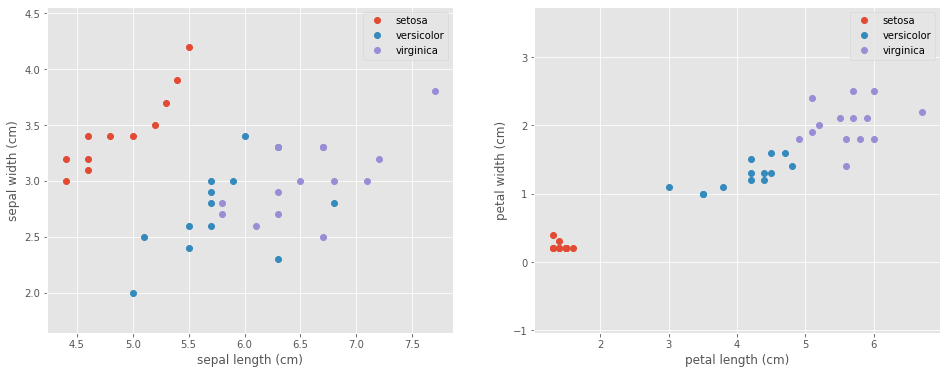

In [13]:
_, _, test_data, test_labels = get_iris_data()
plot_data(test_data, test_labels.argmax(1))

You can use any of the following columns to get the best model: 
['keras_info/loss', 'keras_info/accuracy', 'keras_info/val_loss', 'keras_info/val_accuracy'].
Loss is 0.4804
Tuned accuracy is 0.6842
The original un-tuned model had an accuracy of 0.3684


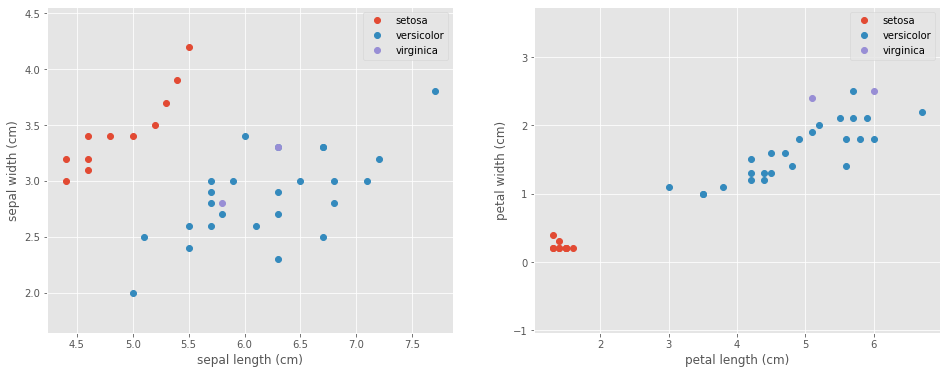

In [14]:
# Obtain the directory where the best model is saved.
print("You can use any of the following columns to get the best model: \n{}.".format(
    [k for k in analysis.dataframe() if k.startswith("keras_info")]))
print("=" * 10)
logdir = analysis.get_best_logdir("keras_info/val_loss", mode="min")
# We saved the model as `model.h5` in the logdir of the trial.
from tensorflow.keras.models import load_model
tuned_model = load_model(logdir + "/model.h5")

tuned_loss, tuned_accuracy = tuned_model.evaluate(test_data, test_labels, verbose=0)
print("Loss is {:0.4f}".format(tuned_loss))
print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
print("The original un-tuned model had an accuracy of {:0.4f}".format(original_accuracy))
predicted_label = tuned_model.predict(test_data)
plot_data(test_data, predicted_label.argmax(1))

We can compare the performance of the best model by visualizing predictions compared to the ground truth.

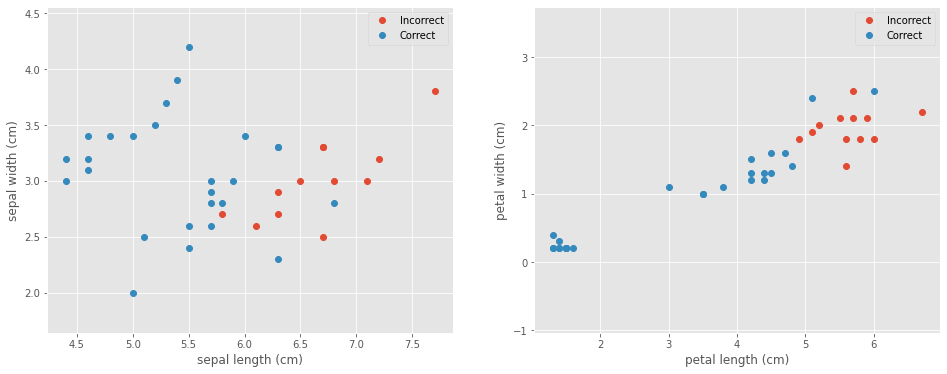

In [15]:
def plot_comparison(X, y):
    # Visualize the data sets
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for target, target_name in enumerate(["Incorrect", "Correct"]):
        X_plot = X[y == target]
        plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.axis('equal')
    plt.legend();

    plt.subplot(1, 2, 2)
    for target, target_name in enumerate(["Incorrect", "Correct"]):
        X_plot = X[y == target]
        plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
    plt.xlabel(feature_names[2])
    plt.ylabel(feature_names[3])
    plt.axis('equal')
    plt.legend();
    
plot_comparison(test_data, test_labels.argmax(1) == predicted_label.argmax(1))

## Extra - use Tensorboard for results

You can use TensorBoard to view trial performances. If the graphs do not load, click `Toggle All Runs`.

In [16]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ~/ray_results/tune_iris